In [8]:
import line_profiler
import pandas as pd
import uproot
#import uproot3
import numpy as np
# import track_time_calibration as ttc
from matplotlib import pyplot as plt
import sys
from tqdm import tqdm
sys.path.insert(1, r'C:\Users\kimyk\OneDrive\Bureau\Master 1\Projet_LPHE_I\ecal_reco\tracking')
sys.path.insert(1, r'C:\Users\kimyk\OneDrive\Bureau\Master 1\Projet_LPHE_I\ecal_reco\utils')
from track import Track
from track3D import Track3D
from hit import Hit
from data_loading import *


In [9]:
file_path = r'C:\Users\kimyk\OneDrive\Bureau\Master 1\Projet_LPHE_I\ecal_reco\test_import_root\data_0000\data_0000.root' ## later, one can use concatenation of data_0001.root - data_0008.root files as well. One is enough for testing

df_hits = load_dataset(file_path)
og_len = len(df_hits)
df_hits.query('n_hits > 6', inplace=True)
df_hits.query('n_hits < 50', inplace=True)
new_len = len(df_hits)
print('selected {:.2f}% of all events'.format(new_len/og_len * 100))

selected 51.28% of all events


In [10]:
## This function provide the parameters x0 (or y0 depending on which hits we provide) and tx the angle of the trac
def create_tracks(df, plot = False):
    tracks = []
    nb_events = len(df['n_hits'])
    steps = 9
    buff_start = None
    buff_evt_idx = None
    dts = []
    for index, row in tqdm(df.iterrows(), total = df.shape[0]):
        channels = row['tofpet_channel']
        tofpet_id = row['tofpet_id']
        hits = [Hit(row,i) for i in range(row['n_hits'])]
        hitsX = [h for h in hits if h.is_sidex]
        hitsY = [h for h in hits if not h.is_sidex]
        
        ## Some events don't have three hits on one of the two sides and are thus not considered
        if len(hitsX) > 3 and len(hitsY) > 3:
            # get track parameters
            track = Track3D(hits)
            tracks.append(track)

            ## check if track has a "good" chi2 value
            if track.is_good_2D_fit():
            
                # worth making a precise track
                #track.precise_track()
                
                ## compute the time of the track
                dt = track.get_time_interval()
                if dt is not None:
                    dts.append(dt)


    return tracks, dts
    

In [11]:
# getting tracks
tracks, dts = create_tracks(df_hits.head(1000))
# %reload_ext line_profiler
# %lprun -f create_tracks create_tracks(df_hits.head(10))

100%|██████████| 1000/1000 [00:16<00:00, 61.02it/s]


####### Track # 144
Reduced chi^2 = 0.25
t = -0.41,	 x0 = 37.21
Reduced chi^2 = 0.50
t = -0.74,	 x0 = 43.69


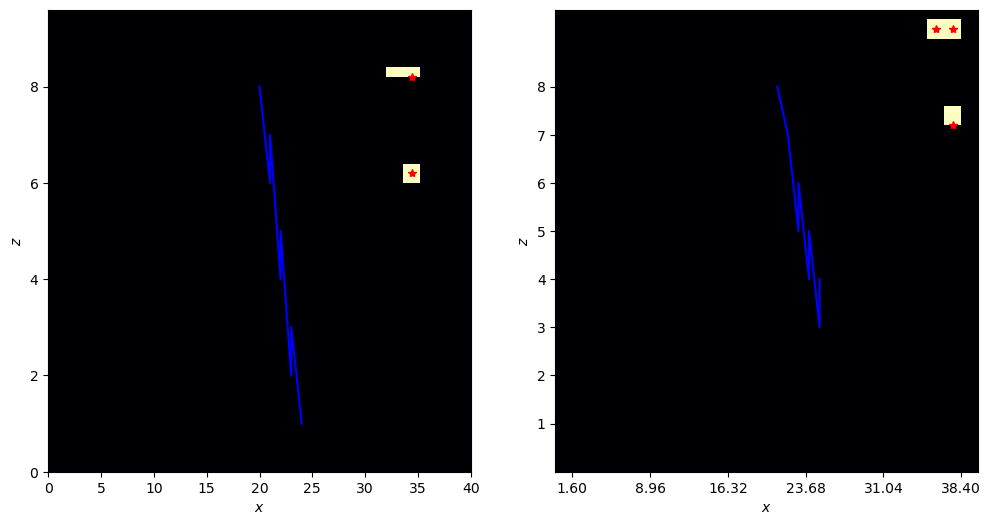

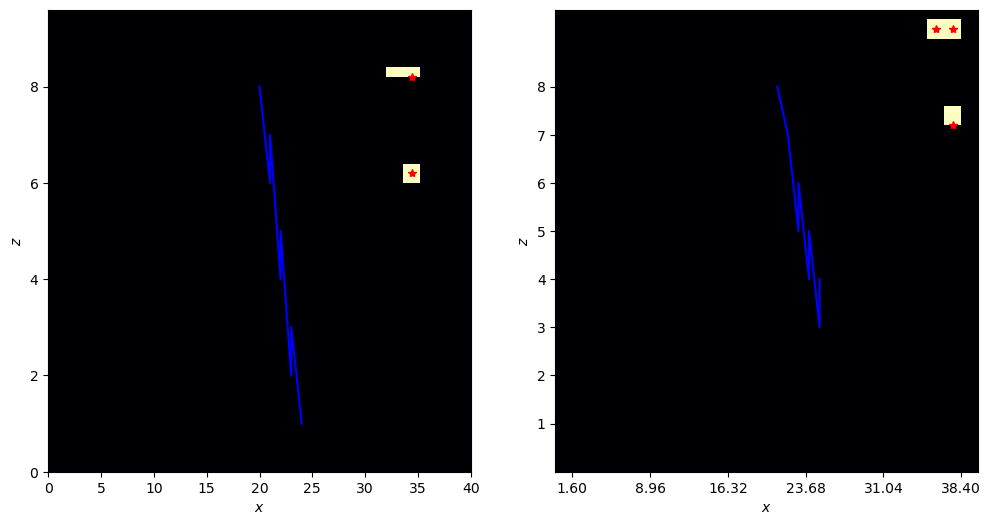

In [12]:
# testing individual outputs
good_tracks = [t for t in tracks if t.is_good_2D_fit()]
i = np.random.randint(0, len(tracks))
print('####### Track # {}'.format(i))
t = tracks[i]
t.print(True)
# t.precise_track()
# print('after')
# t.print(True)

####### Track # 182


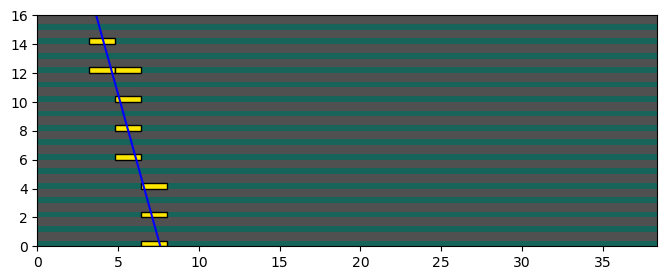

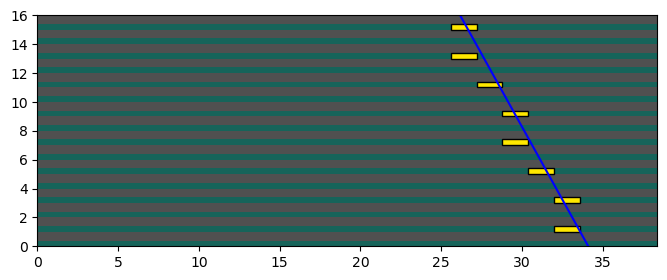

In [13]:
from track_reconstruction import plot_hits
i = np.random.randint(0, len(tracks))
print('####### Track # {}'.format(i))
t = tracks[i]
all_hits = t.x.hits.copy()
all_hits.extend(t.y.hits)
fig1, axs1 = plot_hits(all_hits, True)
fig2, axs2 = plot_hits(all_hits, False)
fig1.set_figheight(3)
fig1.set_figwidth(8)
fig2.set_figheight(3)
fig2.set_figwidth(8)
z = np.linspace(0, 16)
x = t.x.t*z+t.x.x0
y = t.y.t*z+t.y.x0
axs1.plot(x, z, 'b-')
axs2.plot(y, z, 'b-')

FileNotFoundError: [Errno 2] No such file or directory: '../../figs/example_Hough_large.pdf'

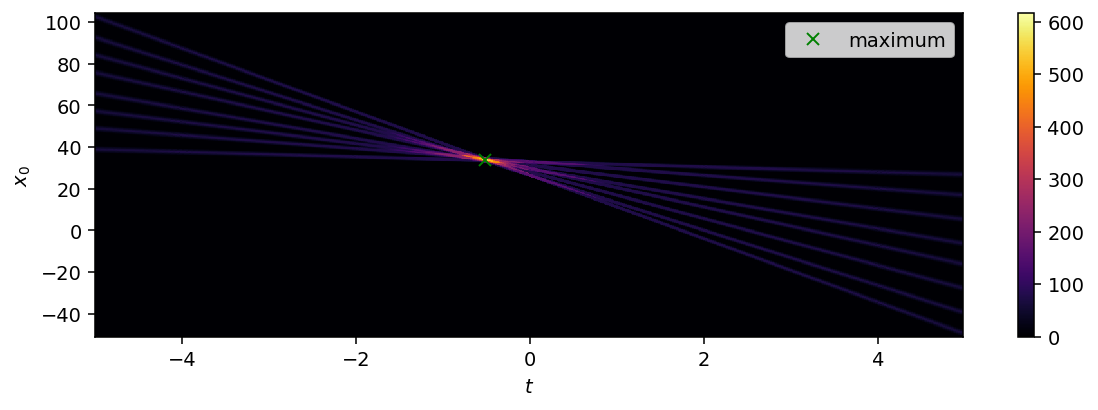

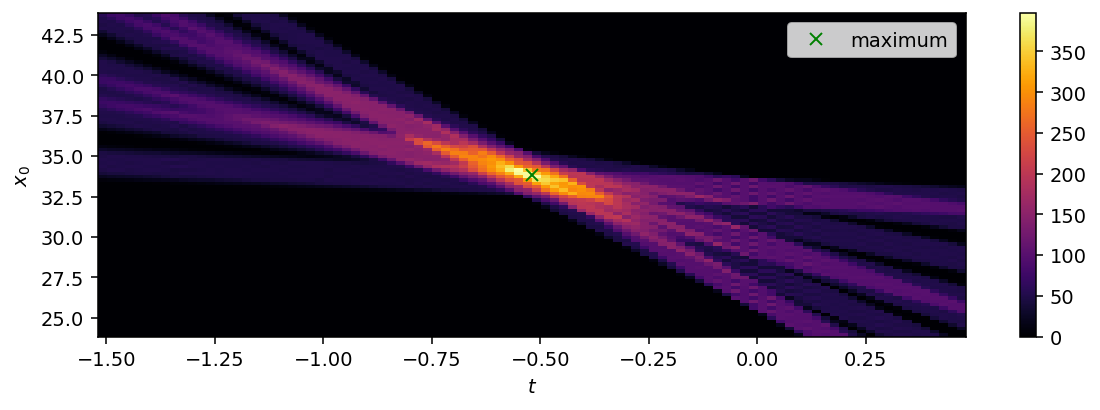

In [14]:
# fig1.savefig('../../figs/example_track_fit_bis1.pdf', )
# fig2.savefig('../../figs/example_track_fit_bis2.pdf', )
fig1, fig2 = t.y.find_track(sampling=20, angle_sampling=480, plot=True)
fig1.savefig('../../figs/example_Hough_large.pdf')
fig2.savefig('../../figs/example_Hough_etroit.pdf')

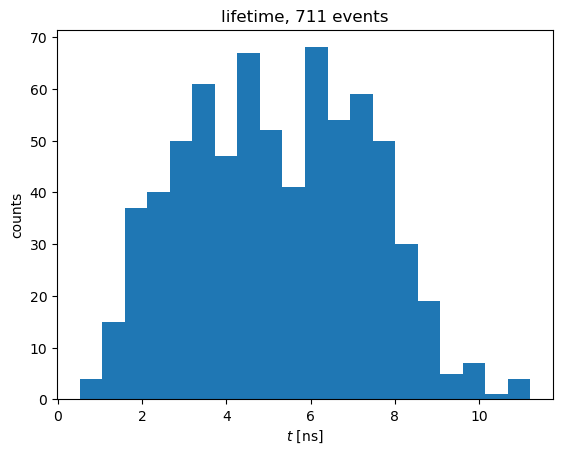

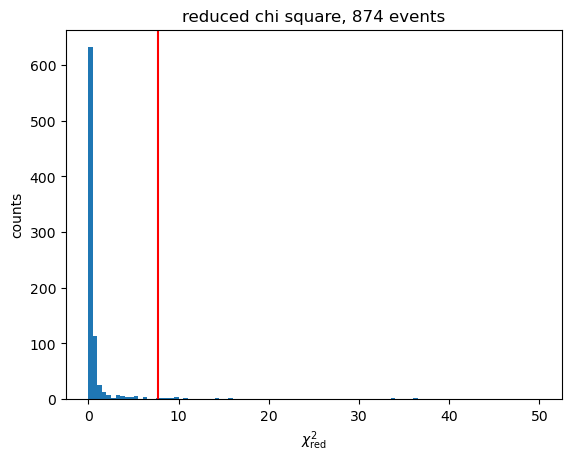

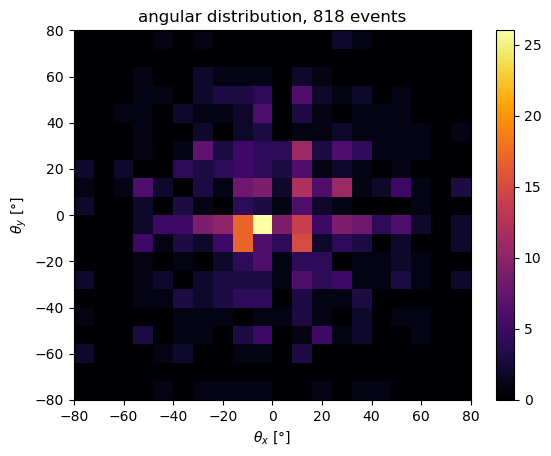

In [ ]:
# plotting lifetime and reduced chi-square distribution
plt.figure()
plt.title('lifetime, {} events'.format(len(dts)))
plt.hist(np.array(dts)*6.25, bins = 20)
# plt.yscale('log')
plt.xlabel('$t$ [ns]')
plt.ylabel('counts')

chi_squares = [track.reduced_chi2() for track in tracks if track.reduced_chi2() is not None]
plt.figure()
plt.title('reduced chi square, {} events'.format(len(chi_squares)))
plt.hist(chi_squares, bins = 100, range = [0, 50])
plt.axvline(x = 2 * 3.841, ymin = 0.0, ymax = 1.0, color = 'r')
plt.xlabel('$\chi^2_{\mathrm{red}}$')
plt.ylabel('counts')

thetas_x = [np.tan(t.x.t) * 180 / np.pi for t in tracks if t.is_good_2D_fit()]
thetas_y = [np.tan(t.y.t) * 180 / np.pi for t in tracks if t.is_good_2D_fit()]
plt.figure()
plt.title('angular distribution, {} events'.format(len(thetas_x)))
plt.hist2d(thetas_x, thetas_y, bins = 20, range = [[-80, 80], [-80, 80]], cmap = 'inferno')
plt.xlabel(r"$\theta_x$ [°]")
plt.ylabel(r"$\theta_y$ [°]")
plt.colorbar()

In [ ]:
# testing the Kalman filter
i = np.random.randint(0, len(tracks))
print('####### Track # {}'.format(i))
t = tracks[i]
t.kalman_filter()

####### Track # 32
